# Intro

Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Let's predict if a given photo represents lungs with penumonia.

# Setup

## Load libraries

In [1]:
import cv2
import gc
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from time import time

ASSETS = './assets/'

In [2]:
def reset_session():
    ops.reset_default_graph()
    gc.collect()
    K.clear_session()
    
reset_session()

# Explore data

## Number of images per a set

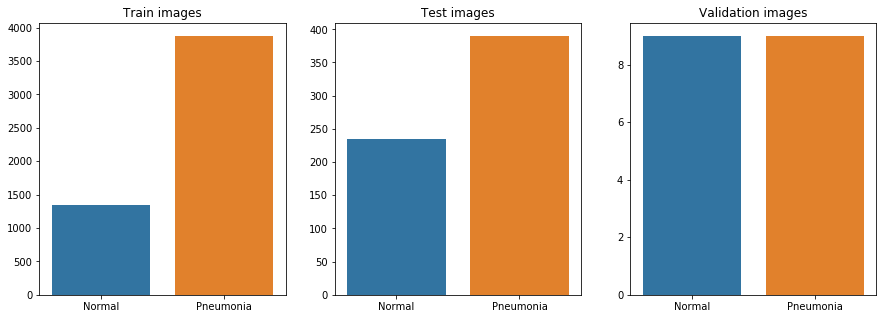

In [3]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def display_image_counts(images_set, index, label):
    normal_count = len(os.listdir(f'{ASSETS}{images_set}/NORMAL'))
    pneumonia_count = len(os.listdir(f'{ASSETS}{images_set}/PNEUMONIA'))
    plt.subplot(1, 3, index)
    plt.title(label)
    sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_count, pneumonia_count])

display_image_counts('train', 1, 'Train images')
display_image_counts('test', 2, 'Test images')
display_image_counts('val', 3, 'Validation images')

plt.show()

## Display sample images from each set

train - NORMAL


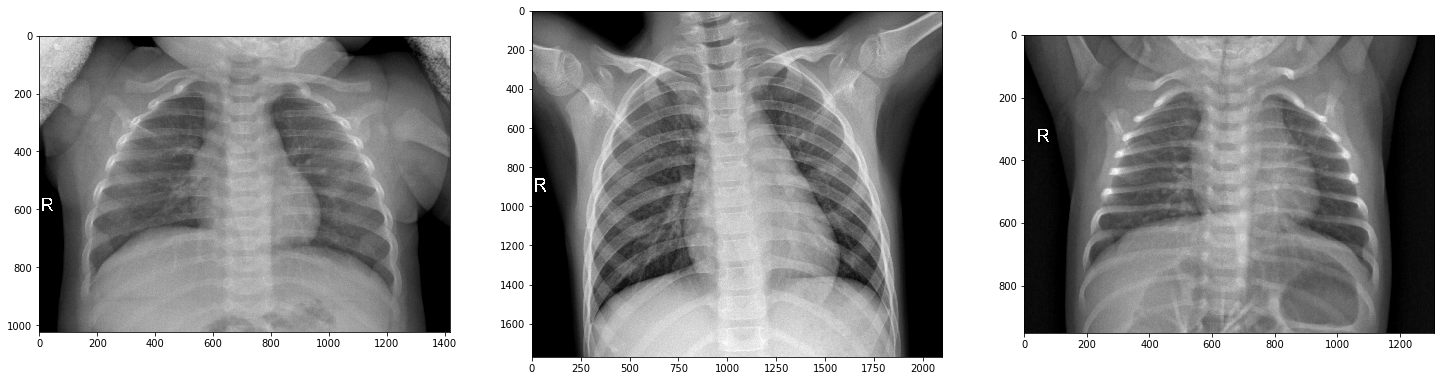

train - PNEUMONIA


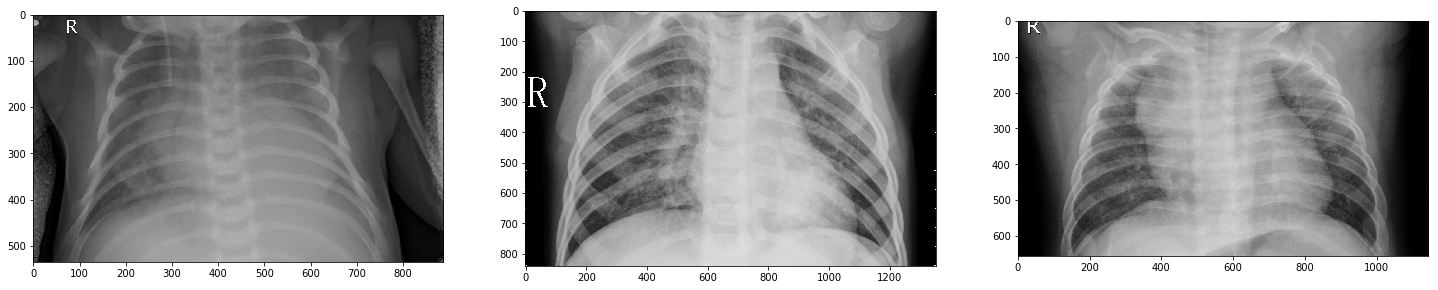

test - NORMAL


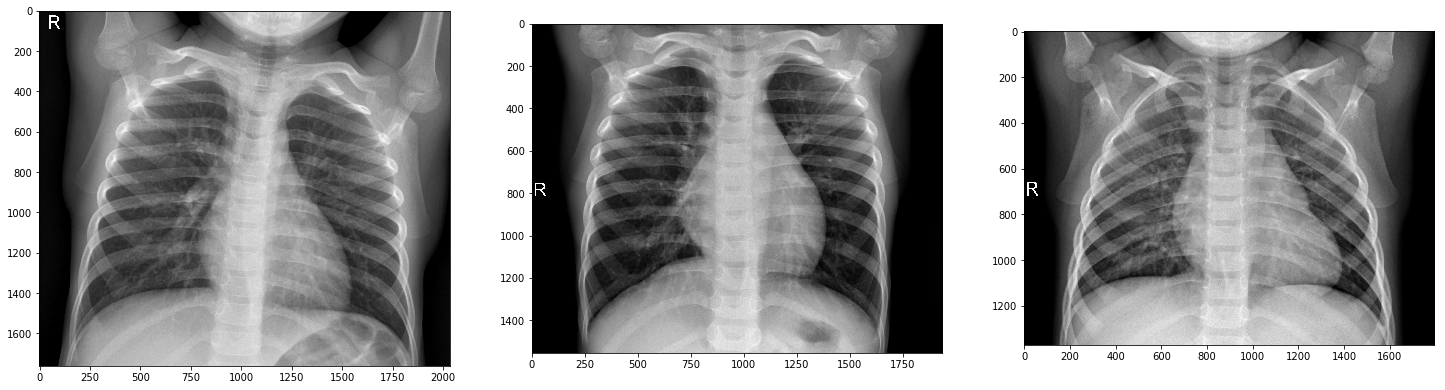

test - PNEUMONIA


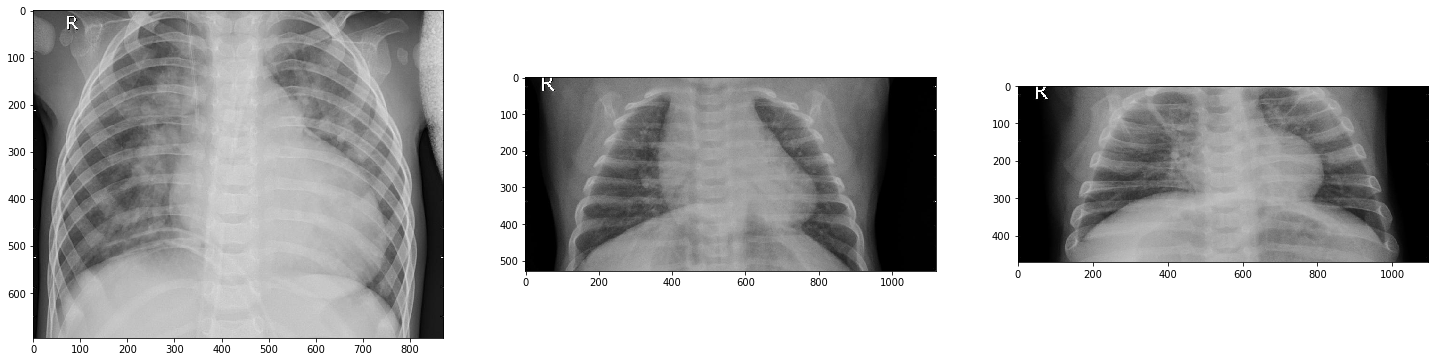

val - NORMAL


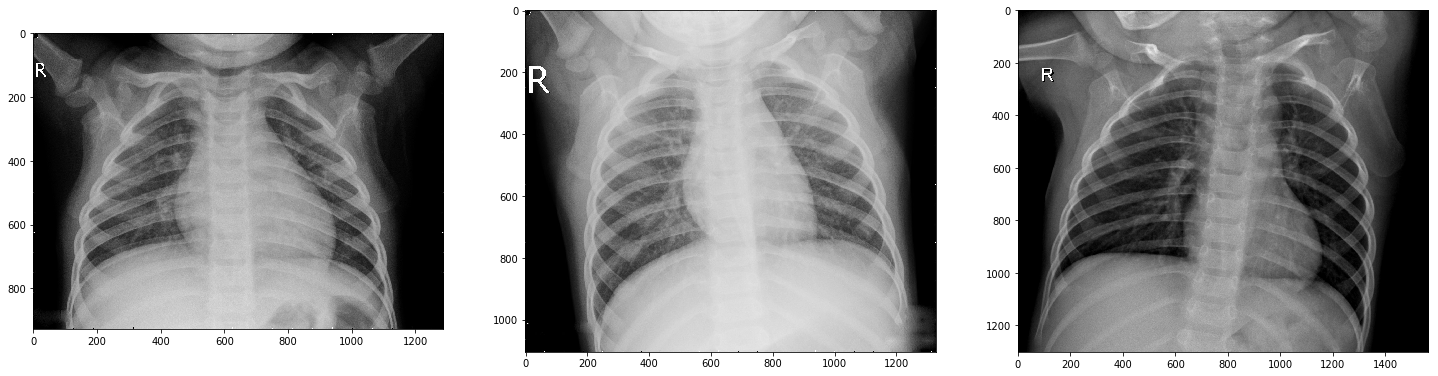

val - PNEUMONIA


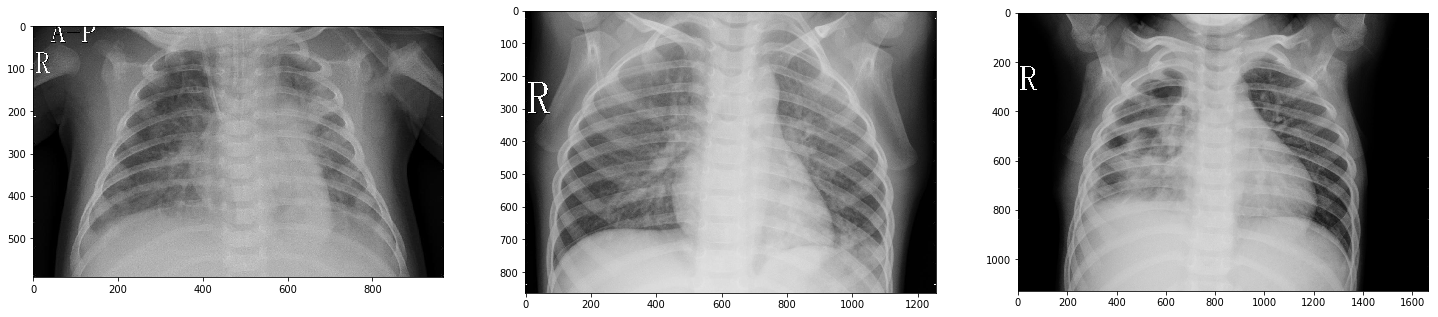

In [4]:
def list_images(images_set, images_class, count = 3):
    print(f'{images_set} - {images_class}')
    plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        plt.subplot(1, count, idx + 1)
        plt.imshow(image)
    plt.show()

list_images('train', 'NORMAL')
list_images('train', 'PNEUMONIA')

list_images('test', 'NORMAL')
list_images('test', 'PNEUMONIA')

list_images('val', 'NORMAL')
list_images('val', 'PNEUMONIA')

# Model definition

## Tensorflow generators

In [3]:
rescale = 1./255
target_size = (300, 300)
batch_size = 128
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=[-20, 20],
    height_shift_range=[-20, 20],
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    f'{ASSETS}train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    f'{ASSETS}test',
    target_size=target_size,
    class_mode=class_mode
)

val_datagen = ImageDataGenerator(rescale=rescale)

val_generator = val_datagen.flow_from_directory(
    f'{ASSETS}val',
    target_size=target_size,
    class_mode=class_mode
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## InceptionV3 model

### Load original model

In [6]:
inception_model = InceptionV3(
    weights=None,
    include_top=False, 
    input_shape=(300, 300, 3)
)
inception_model.load_weights(f'{ASSETS}inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in inception_model.layers:
    layer.trainable = False

### Add custom final layers & compile

In [7]:
x = inception_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=inception_model.input, outputs=x)

# model.summary()

model.compile(
    optimizer=Adam(lr=1e-5),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

## Training the model

### Calculate class weights for paying more attention to under-represented classs

In [18]:
class_weights = class_weight.compute_class_weight(
    'balanced', 
    np.unique(train_generator.classes), 
    train_generator.classes
)
print('Class weights:', class_weights)

Class weights: [1.9448173  0.67303226]


### Callbacks

In [15]:
lr_reduction_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    cooldown=5,
    verbose=1
)

early_stopping_cb = EarlyStopping(
    min_delta=1e-4,
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint_cb = ModelCheckpoint(
    "./artifacts/categorical-2/{epoch:02d}-val_accuracy-{val_accuracy:.4f}-val_loss-{val_loss:.4f}.hdf5",
    monitor='val_accuracy', 
    save_best_only=True
)

callbacks = [lr_reduction_cb, early_stopping_cb, model_checkpoint_cb]

### Train the model

In [4]:
model = load_model('./artifacts/categorical-1/08-val_accuracy-0.7965-val_loss-0.5642.hdf5')

W0924 01:34:18.575995 139836164548416 deprecation.py:323] From /home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
start_time = time()

history = model.fit_generator(
    train_generator,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[lr_reduction_cb, model_checkpoint_cb],
    class_weight=class_weights
)

print('Training time: ', time() - start_time)

Epoch 1/5
41/41 [==============================] - 194s 5s/step - loss: 0.0783 - accuracy: 0.9686 - val_loss: 0.9140 - val_accuracy: 0.7292
Epoch 2/5
41/41 [==============================] - 191s 5s/step - loss: 0.0817 - accuracy: 0.9668 - val_loss: 0.7650 - val_accuracy: 0.7564
Epoch 3/5
41/41 [==============================] - 193s 5s/step - loss: 0.0811 - accuracy: 0.9686 - val_loss: 0.6411 - val_accuracy: 0.7756
Epoch 4/5
41/41 [==============================] - 194s 5s/step - loss: 0.0744 - accuracy: 0.9699 - val_loss: 0.7597 - val_accuracy: 0.7532
Epoch 5/5
41/41 [==============================] - 192s 5s/step - loss: 0.0788 - accuracy: 0.9720 - val_loss: 0.6153 - val_accuracy: 0.7756
Training time:  964.9371538162231


### Loss and accuracy over epochs - after 20 epochs

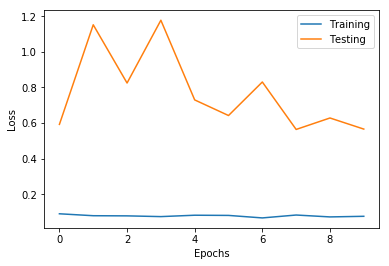

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

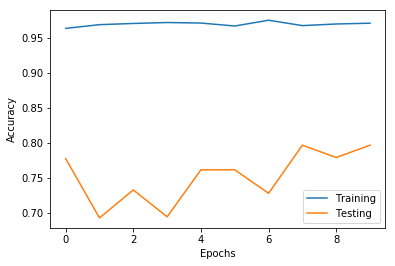

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

### Loss and accuracy over epochs - after 25 epochs

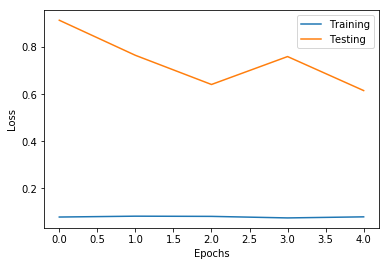

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

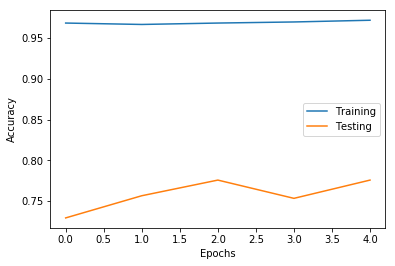

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

Evaluate model against the validation set

## Verifying the model

In [23]:
for path in sorted(os.listdir('./artifacts/categorical-2/')):
    print(path)

02-val_accuracy-0.7564-val_loss-0.7650.hdf5
03-val_accuracy-0.7756-val_loss-0.6411.hdf5


In [7]:
final_model = load_model('./artifacts/categorical-1/08-val_accuracy-0.7965-val_loss-0.5642.hdf5')

In [26]:
val_result = final_model.evaluate_generator(val_generator, steps=len(test_generator), verbose=1)

print(f'Validation Loss: {round(val_result[0], 2)}')
print(f'Validation Accuracy: {round(val_result[1] * 100, 2)}%')

20/20 [==============================] - 8s 392ms/step - loss: 0.6028 - accuracy: 0.7500
Validation Loss: 0.6
Validation Accuracy: 75.0%


In [9]:
final_model = load_model('./artifacts/categorical-2/03-val_accuracy-0.7756-val_loss-0.6411.hdf5')

In [10]:
val_result = final_model.evaluate_generator(val_generator, steps=len(test_generator), verbose=1)

print(f'Validation Loss: {round(val_result[0], 2)}')
print(f'Validation Accuracy: {round(val_result[1] * 100, 2)}%')

20/20 [==============================] - 13s 638ms/step - loss: 0.4443 - accuracy: 0.7500
Validation Loss: 0.44
Validation Accuracy: 75.0%


In [13]:
class_map = {v: k for k, v in train_generator.class_indices.items()}
print(class_map)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [11]:
def verify_predictions(images_set, images_class, count = 5):
    print(f'{images_set} - {images_class}')
    plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        plt.subplot(1, count, idx + 1)
        plt.imshow(image)
        image = cv2.resize(image, (300, 300)) * 1./255
        prediction = final_model.predict(np.array([image]))
        predicted_class = class_map[prediction.argmax(axis=-1)[0]]
        color = 'black' if predicted_class == images_class else 'red'
        plt.title(f'Class: {images_class}\nPredicted: {predicted_class}', color=color)
    plt.show()

#### Prediction on the test and validation datasets

train - NORMAL


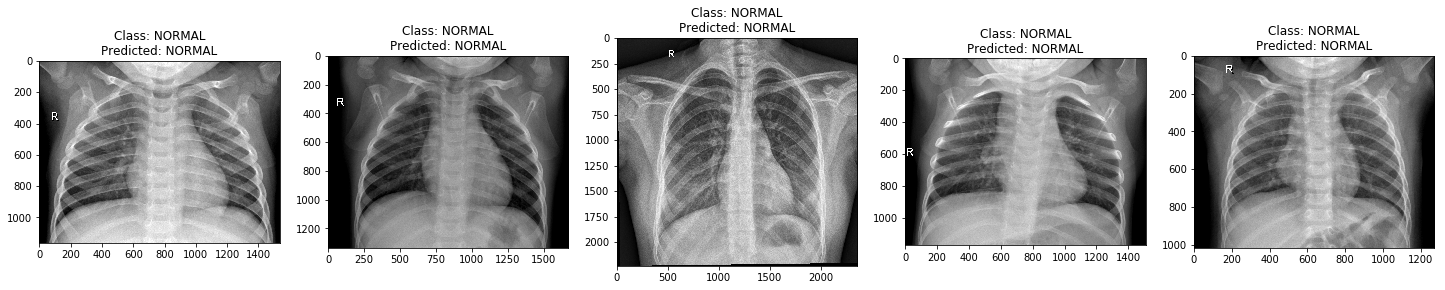

train - PNEUMONIA


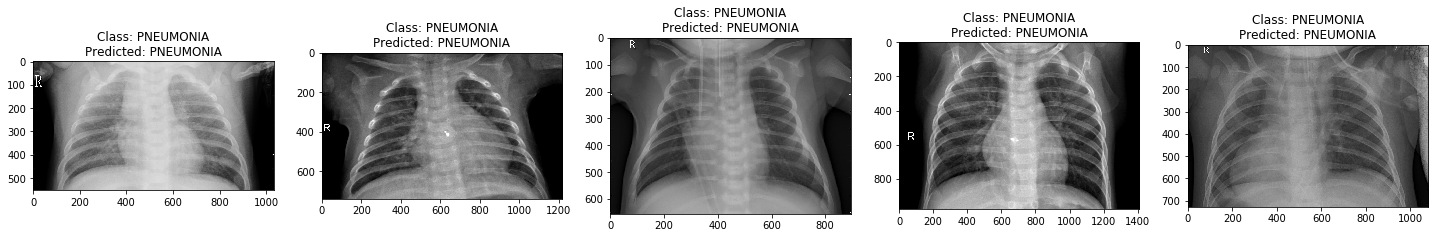

test - NORMAL


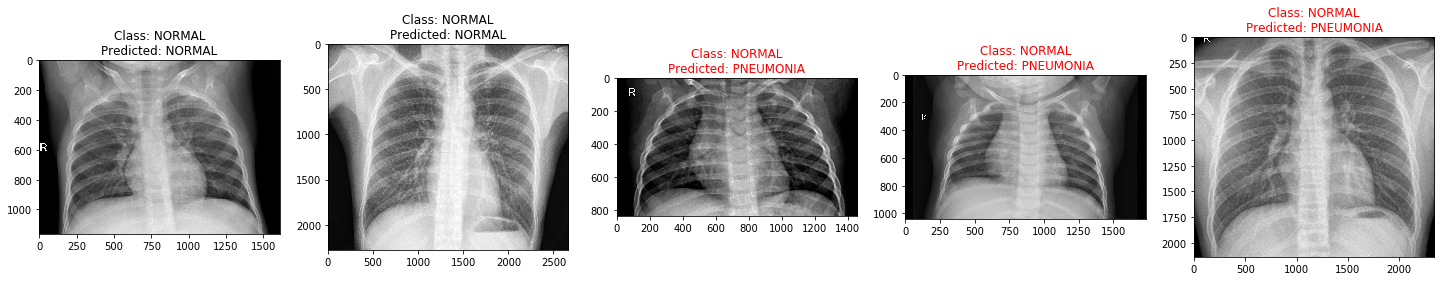

test - PNEUMONIA


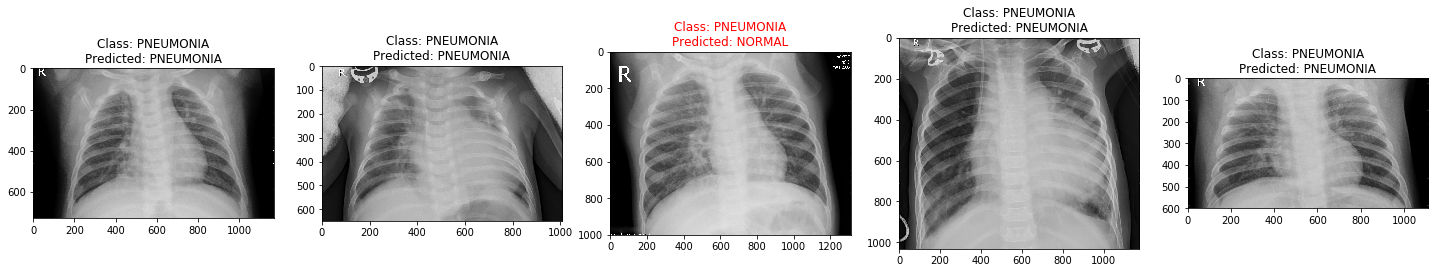

val - NORMAL


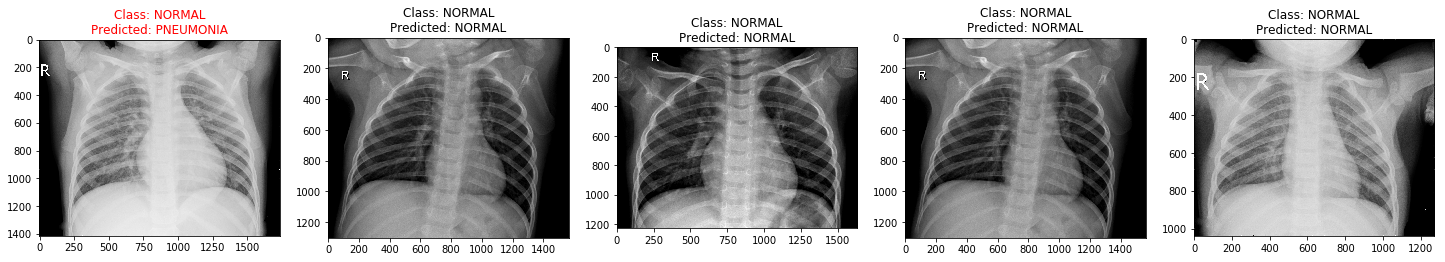

val - PNEUMONIA


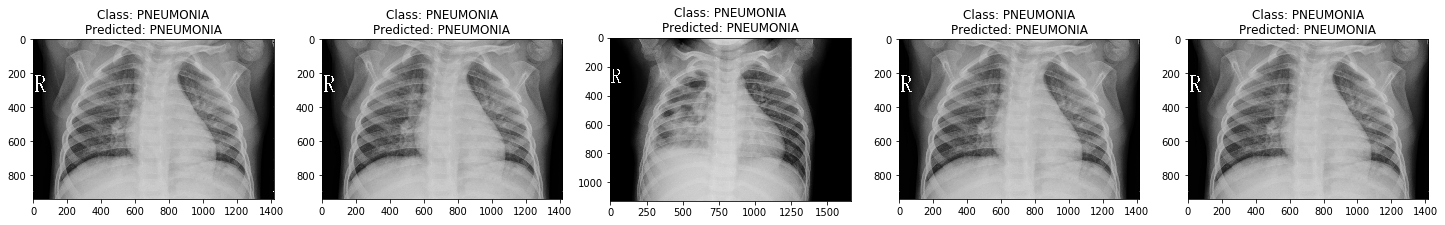

In [14]:
verify_predictions('train', 'NORMAL')
verify_predictions('train', 'PNEUMONIA')
verify_predictions('test', 'NORMAL')
verify_predictions('test', 'PNEUMONIA')
verify_predictions('val', 'NORMAL')
verify_predictions('val', 'PNEUMONIA')

#### Confusion matrix

In [15]:
predicted_classes = final_model.predict_generator(val_generator, steps=len(val_generator), verbose=1)
predicted_classes = predicted_classes.argmax(axis=-1)
true_classes = val_generator.classes

1/1 [==============================] - 2s 2s/step


In [16]:
print('Precision score: ', round(precision_score(true_classes, predicted_classes) * 100, 2))
print('Recall score: ', round(recall_score(true_classes, predicted_classes) * 100, 2))
print('F1 score: ', round(f1_score(true_classes, predicted_classes) * 100, 2))

Precision score:  30.0
Recall score:  37.5
F1 score:  33.33


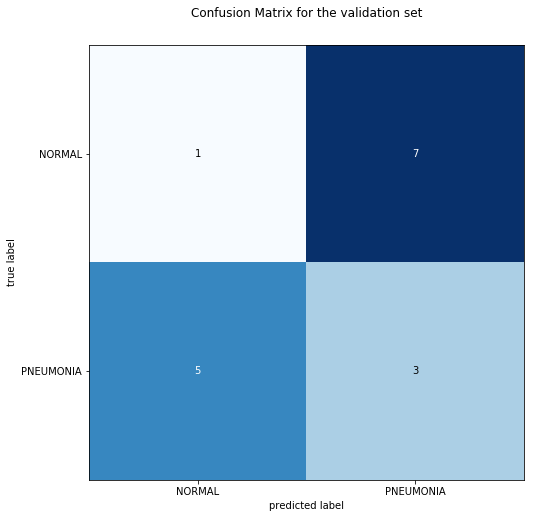

In [30]:
classes = [k for k, v in train_generator.class_indices.items()]
cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), hide_ticks=True)
plt.xticks(range(len(class_map)), classes)
plt.yticks(range(len(class_map)), classes)
plt.title('Confusion Matrix for the validation set')
plt.show()

20/20 [==============================] - 12s 592ms/step


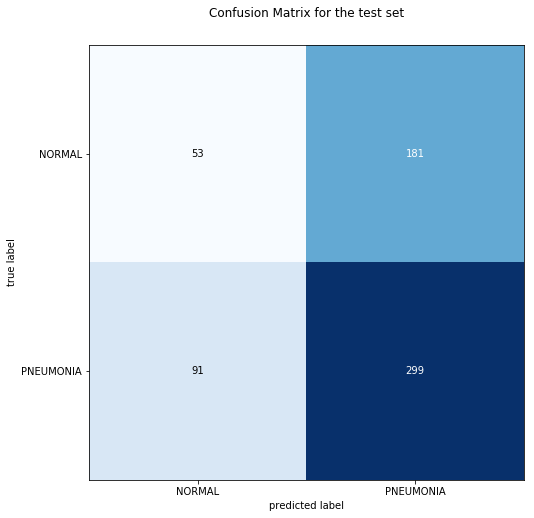

In [33]:
predicted_classes = final_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = predicted_classes.argmax(axis=-1)
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), hide_ticks=True)
plt.xticks(range(len(class_map)), classes)
plt.yticks(range(len(class_map)), classes)
plt.title('Confusion Matrix for the test set')
plt.show()